# Embeddings

DL cannot input raw text - the text must be vectorised
- words to vectors
- characters to vectors
- n-grams of words or characters to vectors.

In each case, the units are called tokens. Two main tokenisations:
- one-hot
- token (usually word) embeddings.

##### n-grams 

are sets of consecutive words with maximum length n. 

- For example
"The cat sat on the mat" -> {"the", "cat", "sat", "on", "the", "mat", "the cat", "cat sat", "sat on", "on the", "the mat"} is a *bag of 2-grams*.
- order is lost
- a kind of feature engineering
- used in shallow learning (logistic regression, random forests)
- DL uses RNNs and convnets to learn representations for ordered groups of tokens without any priors. 

##### One-hot encoding
- associate a unique integer $n$ with each word in a dictionary of $N$ 
- then form an $N$ dimensional vector $v$ with components $v_i = \delta_{i, n}$ i.e.

\begin{align*}
v_i = \begin{cases} &1 \text{ if } i == n \\
                    &0 \text{ otherwise } \\
                    \end{cases}
\end{align*}

##### Word embeddings

Dense and low dimensional e.g. 256, 512, 1024), unlike one hot vectors, which are sparse and high dimensional e.g. 20,000.

- Learn word embeddings with the main task - start with random vectors - or
- use pre-trained embeddings.

##### The embedding layer

The embedding layer learns embeddings with every new task.

A structured embedding space is desired.
- words of similar meanings are close
- geometric and semantic relationships match
    - vector wolf-to-dog = vector lion-to-cat and lion-to-wolf = cat-to-dog
- expect different geometries for different tasks (sentiment analysis is very different from classification of legal documents).

This code makes an embedding layer

In [25]:
from tensorlow.keras.layers import Embedding
embedding_layer = Embedding(10000, 64)

with a 10000 word dictionary and an embedding space of 64 dimensions.

It accepts batches of shape `(samples, sequence_length)` and returns a 3D float tensor of shape `(samples, sequence_length, embedding_dimensionality)`.


In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

But merely flattening the embeddings produces a model that treats each word separately. The order is lost. 

We will meet order sensitive models such as RNNs and 1D convnets in a few minutes.

##### Pre-trained embeddings

- Word-to-vec and GLoVe
- Listings 6.8 to 6.11 demonstrate how to tokenise raw text and form the embedding weight array.
- Then, the model is 

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

max_words = 10000
embedding_dim = 100
maxlen = 100

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

The embedding layer is frozen for the same reason as the freezing of the convnet base in the previous section.

The model is trained on just 200 reviews because pre-trained embeddings are thought to be useful on problems with small training sets.

# RNNs

The dense, fully connected layers and the convnet layers have no memory. These *feedforward networks* process each input in turn with no information transfer.

A recurrent neural network (RNN), on the other hand, retains information of past inputs.

The RNN has a feedback loop - the activation $a(t - 1)$ at time $t - 1$ is inputted, along with the sequence term $x(t)$, at time $t$. 

DLWP: the previous activation is called a 'state'. 

The previous activation is weighted and the network learns patterns correlations with earlier inputs by adjusting these weights, in the usual manner.

(Here, we imagine that sequence terms $x(1), x(2), x(3), \ldots$ etc. occur at successive times, even if the sequence is not chronological.)

For example, successive words $x(1), x(2), x(3), \ldots$ of a single movie review.

The state is reset before a new sequence (new movie review) is processed.

Previously, in *feed forward networks*, the entire sequence (review) was treated as a single input vector.

##### Dense Feedforward layer - recap

Suppose the input to a layer is the vector $x = [x_1, x_2, \ldots x_N]^T$ and the output, the activation, is the vector $a = [a_1, a_2, \ldots, a_M]^T$.

There are $M$ output features (one per neuron) and $N$ input features.

The weight matrix is
 \begin{bmatrix}
  W_{11} & W_{12} & \ldots & W_{1N} \\
  W_{21} & W_{22} & \ldots & W_{2N} \\
  \ldots \\
  W_{M1} & W_{M2} & \ldots & W_{MN} \\
 \end{bmatrix}
 
and the bias is $b = [b_1, b_2, \ldots, b_M]$: there are $M \times N + M$ adjustable parameters.

The layer activation, as a vector, is 

$
a = \sigma(W \cdot x + b)
$

which means, in terms of components, 

$
a_i = \sigma\left(\sum_{j = 1}^{N} W_{ij}x_j + b_i\right).
$

##### The simple recurrent layer

There are two inputs: the current input, $x(t)$, and the previous activation, $a(t - 1)$. 

The activation from the RNN layer is 

$
a(t) = \sigma(W \cdot x(t) + U \cdot a(t - 1) + b).
$

The idea is that the previous activation, $a(t - 1)$, can have more or less effect on the current activation. The influence of the previous activation and input is controlled by the weights. The equation for $a(t)$ is recursive,

$
a(t) = f(x(t), a(t-1)) = f(x(t), f(x(t - 1), a(t-2))) = \ldots,
$

so, in principle, the distant past can influence the present.

The RNN layer in pseudocode is

In [ ]:
prev_output = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, prev_output) + b)
    prev_output = output_t

U is an $M \times M$ matrix - or, as a tensor, it has shape (output_features, output_features).

So, there are $M \times N + M \times M + M$ cofficients.

Another way of seeing it: each neuron has $N$ weights for the $N$ input features, $M$ weights for the previous output, and a bias: that's $(N + M + 1)$ coefficients. But there are $M$ units, giving $(N + M + 1) \times M$ coefficients.

Let's look at a keras recurrent model:

In [2]:
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


The number of parameters in the `SimpleRNN` layer, from the above calculation is 

In [36]:
(32 + 32 + 1) * 32

2080

which agrees with `model.summary()`.

The model processes inputs in mini-batches, just as in the feedforward networks, and `SimpleRNN` layers can be stacked just like FF networks. 

Listings 6.22-6.24 show a simple RNN for IMDB, with the restriction to the first 500 words of each review.

The simple RNN falls below the FF MNIST model of chapter 3 (85% cf. 88%).

This is in part due to the short reviews, but also because the simple RNN is just *too* simple. There is a fundamental pathology: *vanishing gradients*. The backpropagated error signal progressively weakens.

Peanuts per hour = peanuts per mile times miles per hour - the  products of gradients

The simple RNN is never used in practice. Instead, engineers turn to more refined RNNs such as the LTSM network.

#### The LSTM layer

The LSTM layer is really a kind of multi-layer with two different activation functions.

Let's quickly revise three common activation functions:

##### Activation functions 

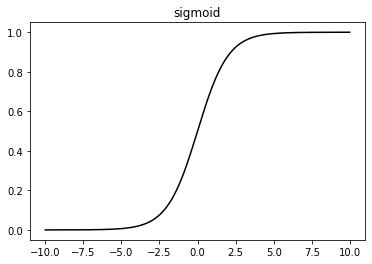

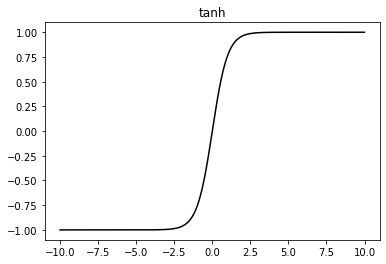

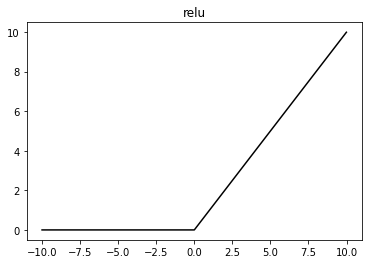

In [2]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def relu(x):
    y = np.zeros(len(x))
    return np.maximum(0, x)

import matplotlib.pyplot as plt

x = np.arange(-10, 10, 0.01)

plt.plot(x, sigmoid(x), 'k')
plt.title('sigmoid')
plt.show()

plt.plot(x, tanh(x), 'k')
plt.title('tanh')
plt.show()

plt.plot(x, relu(x), 'k')
plt.title('relu')
plt.show()

#### LSTM pseudocode 

```
memory = gated_prev_memory + gated_simple_RNN
output_t = gated_tanh-activation(memory)
```

##### Explanation

- The LSTM layer output is `output_t`. The LSTM layer output at $t - 1$ is `prev_output`.
- A gate is a simple RNN layer with sigmoid activation,
```
sigmoid-activation(dot(input_t, W) + dot(prev_output, U) + b)
```
- 'Gated' means multiply by a gate. 
- All gates and simple RNN layers have their own parameters $(W, U, b)$.
- Simple_RNN: 
```tanh-activation(dot(input_t, W) + dot(prev_output, U) + b)
```



#### The LSTM layer in detail*

[A popular blog account](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) and [there's always Wikipedia](https://en.wikipedia.org/wiki/Long_short-term_memory)

##### Memory

The LTSM layer has a memory, called 'carry' by Chollet and, confusingly, 'state' by other authors. 

----

1. A forget gate:

$
f(t) = \sigma_g(W_f \cdot x(t) + U_f \cdot a(t - 1) + b_f)
$

$\sigma_g$ is a sigmoid, outputing in $[0, 1]$, a kind of smoothed 'gate'.

----

2. An input gate:

$
i(t) = \sigma_g(W_i \cdot x(t) + U_i \cdot a(t - 1) + b_i)
$

which we can also imagine as open or closed or in-between.

----

3. A simple RNN layer - to inject new information into the memory

$
k(t) = \sigma_h(W_k \cdot x(t) + U_k \cdot a(t - 1) + b_k)
$

where $\sigma_h$ is the $\tanh$ activation.

----

4. Putting all this together:

```
memory = gated_prev_memory + gated_simple_RNN
```

$
c(t) = f(t) * c(t - 1) + i(t) * k(t)
$



##### Output

----

1. An output gate

$
o(t) = \sigma_d(W_o \cdot x(t) + U_o \cdot a(t - 1) + b_o)
$

----
2. which multiplies, or gates, the memory

```
output_t = output_gate(t) * tanh-activation(memory)
```

$
a(t) = o(t) * \sigma_h(c(t))
$





$\sigma_h$ is a hyperbolic tangent (or, in a 'peephole' LSTM, the identity function $\sigma(x) = x$). 


##### Parameters

There are four $(W, U, b)$ units - 3 gates and the new information RNN, $k$. Each set of $(W, U, b)$ units has $M times (M + N + 1)$ trainable parameters. Hence an LTSM layer has $4M(M + N + 1)$ tuneable parameters. 

In [4]:
import tensorflow.keras.models as models, tensorflow.keras.layers as layers

time_steps = 10
input_feats = 4
output_feats = 8

model = models.Sequential()
model.add(layers.LSTM(output_feats, input_shape=(time_steps, input_feats)))
print('Trainable params: ', 4 * output_feats * (output_feats + input_feats + 1), '\n')
model.summary()

Trainable params:  416 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 8)                 416       
Total params: 416
Trainable params: 416
Non-trainable params: 0
_________________________________________________________________


##### LSTM comparison

A very simple LSTM

In [ ]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

scores 89% validation accuracy, improving on the simple RNN accuracy (85%) for the MNIST dataset (because it suffers less from vanishing gradients) and is slightly better than the fully connected model of DLWP Chapter 3 (where the reviews were not truncated at 500 words). 

LSTM might perform better with hyper-parameter tuning and regularisation but the main issue is that the salient information in the reviews is not sequential - frequencies of positive and negative words are enough for good prediction.  

# Sequence processing with convnets

Convnets are successful at (some) visual problems because they exploit 2D locality.

We expect that 1D convnets might also have applications in sequence data.

In fact they offer a fast alternative to RNNs for text processing and time-series forcasting.

Imagine a 1D convolutional filter of length 5 tokens sliding across a sequence. The same transformation is performed on each patch - so the filter can recognise patterns anywhere in the input sequence.

1D convolutions can be pooled, as well, with receptive fields of 5, 7 or 9.

Here is the model of Listing 6.46:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

- The global max-pooling layer finds the max over the entire input. 
- Validation accuracy is less than the previous LSTM model, but the training run is quicker.

# Advanced RNN's

Three techniques: recurrent dropout, stacked layers and bidirectional layers are applied to the temperature-forecasting problem: given 14 weather measurements taken at ten minute intervals over several years (the Jena dataset), can we predict (for example) the next temperature reading from 24 hours worth of data.

###### Common sense baseline

Simply suppose that the temperature 24 hours from now is just the current temperature. This baseline has an MAE of 0.29 or 2.57C. 

###### DL baseline 

```
model = Sequential()
model.add(layers.Flatten...)
model.add(layers.Dense(32, activation='relu')
model.add(layers.Dense(1))
```
Note the single neuron final layer - no activation - this is a regression problem. 

The DL baseline is worse than the common-sense baseline.

The common sense solution might lie in the hypothesis space but might be effectively unlearnable. Parameter learning is not infallible and it can fail to find simple solutions to simple problems.

###### RNN baseline

Listing 6.39 shows a Gated Recurrent Unit model (GRU).
```
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)
```

The GRU is similar, but represetationally weaker than, the LSTM. However, it runs faster.

MAE: 2.35C, better than common sense (2.57C), but can we do better?

##### Dropout

Remembert the idea is to break chance correlations by zero'ing random units.

The same dropout mask, in RNNs, is applied to each step rather than a different mask at each timestep.

```
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
```

The GRU with dropout at 0.2 shows improvement over the baseline GRU on the Jena data - the model does not overfit.

##### Stacked recurrent layers

Remember the DL workflow: find the simplest model that doesn't overfit and then enlarge the model until it overfits. Finally, regularise the overfitting model.

Stacking is very easy in keras - Listing 6.41.

```
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))
```

The two recurrent layer model still does not overfit too badly, so another layer could be added
- but there will be a computational cost
- and adding a second layer didn't have a great effect, so the returns might be diminishing.






##### Bidirectional RNNs

RNNs are applied to ordered data - but which order? Chronological or anti-chronological? Or, for non-chronological sequences, from left to right or right to left?

Training a one layer GRU with anti-chronological Jena data underperforms the same network with chronological data. That makes sense: the recent past is more salient to temperature prediction than the more distant past.

But a reverse-direction LSTM equals the performance normal direction LSTM on IMDB data.

It seems word order is important in natural language processing - but *which* order is irrelevant!

In general we expect reversed order training to yield different representation from forward order training. 



Representations that are different but useful are worth exploiting in DL modeling.

The bidirectional RNN merges the forward and backward order trained RNN layers.

This is an example of ensembling - merging different models.

We find some improvement with the bidirectional LSTM over the regular LSTM on IMDB - overfitting sooner (there are twice as many parameters). Now, we can try regularisation.

The bidirectional GRU does not perform better than the regular model on the temperature task - because the anti-chronological half is not, in this case, sufficiently infomative.

##### Even more advanced

- Adjust the number of units in each recurrent layer
- Try different learning rates
- Substitute LSTM layers for GRU layers
- Try a bigger densely connected regressor on top of the recurrent base, or even a stack of dense layers
- Remember to run the best performing models on the test set

In [46]:
import keras
from keras.models import Sequential
from keras import layers

max_features = 10000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


- The global max-pooling layer finds the max over the entire input. 
- Validation accuracy is less than the previous LSTM model, but the training run is quicker. 

##### Combining CNN and RNNs for long sequence processing

1D convnets insensitive to order at lengths greater than the convolution window.

So, stack convnet layers, as we did with vision tasks?

Stacked 1D CNNs don't always work so well: Listing 6.47 shows a stacked model on the Jena data. 
- The results are worse than common sense
- because upper layers access the distant past and we know the distant past is less informative than the recent past in this data set.

Solution: use a convnet, which is computationally cheap, to shorten the sequence and place an RNN, which recognises time-ordering, on top.
- Especially relevant with very long sequences (downsampling is necessary before input to RNN)
- Still not as good as the GRU model on the Jena data, but is significantly faster.

# Summary

- Techniques for sequence data:
    - Tokenise text
    - Word embeddings
    - Recurrent networks
    - Stacked and bidrirectional RNNs
    - 1D convnets for sequence orocessing
    - Combination of convnets and RNNs
- RNNs applicable to
    - timeseries regression/classifiaction, anomaly dertection, sequence labeling (e.g. identifying names or dates in sentences.)
- 1D convnets applicable to
    - machine translation, document classification and spelling correction
- Use an RNN if the sequence data has important global ordering (epsecially for timeseries where the recent past is more predictively informative than the distant past)
- Otherwise, if global order is not important, as in text where keywords are equally informative at the beginning or end of the setence, prefer 1D convnets since they work as well as RNNs but are computationally cheaper.